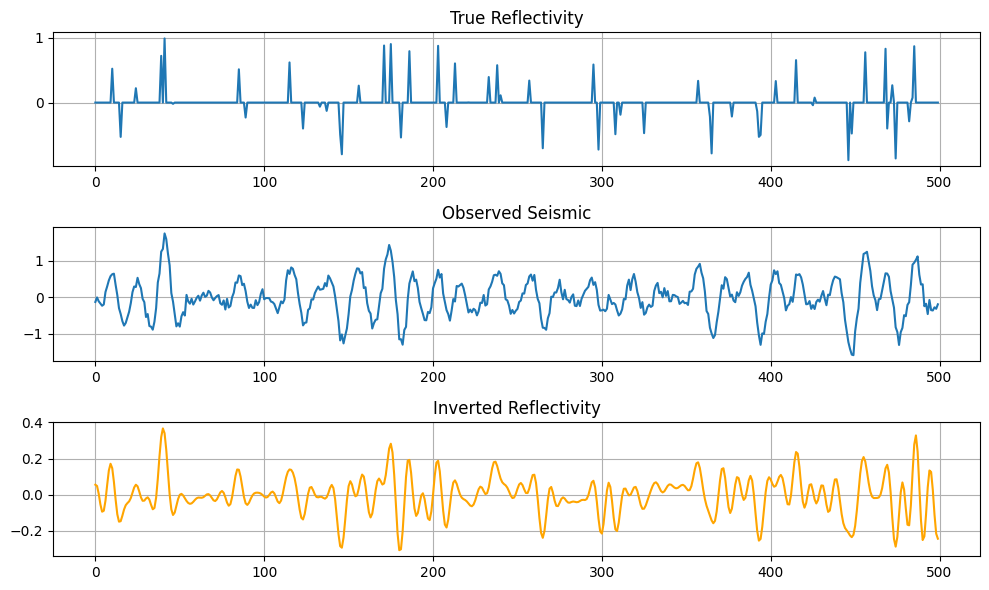

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Generate a Ricker wavelet
def ricker_wavelet(frequency, dt, length):
    t = np.arange(-length / 2, length / 2, dt)
    wavelet = (1 - 2 * (np.pi * frequency * t) ** 2) * np.exp(-(np.pi * frequency * t) ** 2)
    return wavelet, t

# Generate synthetic reflectivity
def generate_reflectivity(num_samples, spike_prob=0.1):
    reflectivity = np.random.choice([0, 1], size=num_samples, p=[1 - spike_prob, spike_prob])
    reflectivity = reflectivity * (np.random.rand(num_samples) - 0.5) * 2  # Random amplitudes
    return reflectivity

# Inversion function
def seismic_inversion(observed_seismic, wavelet, num_iterations=1000, alpha=0.01):
    estimated_reflectivity = np.zeros_like(observed_seismic)
    for _ in range(num_iterations):
        synthetic_seismic = convolve(estimated_reflectivity, wavelet, mode='same')
        residual = observed_seismic - synthetic_seismic
        gradient = convolve(residual, wavelet[::-1], mode='same')
        estimated_reflectivity += alpha * gradient
    return estimated_reflectivity

# Parameters
num_samples = 500
dt = 0.002  # 2 ms
wavelet_frequency = 25  # Hz
wavelet_length = 0.1  # 100 ms

# Generate wavelet, reflectivity, and synthetic seismic
wavelet, t_wavelet = ricker_wavelet(wavelet_frequency, dt, wavelet_length)
reflectivity = generate_reflectivity(num_samples)
synthetic_seismic = convolve(reflectivity, wavelet, mode='same')

# Add noise to the synthetic seismic
noise_level = 0.1
noisy_seismic = synthetic_seismic + noise_level * np.random.randn(num_samples)

# Perform inversion
estimated_reflectivity = seismic_inversion(noisy_seismic, wavelet)

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(reflectivity, label="True Reflectivity")
plt.title("True Reflectivity")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(noisy_seismic, label="Observed Seismic")
plt.title("Observed Seismic")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(estimated_reflectivity, label="Estimated Reflectivity", color="orange")
plt.title("Inverted Reflectivity")
plt.grid()

plt.tight_layout()
plt.show()

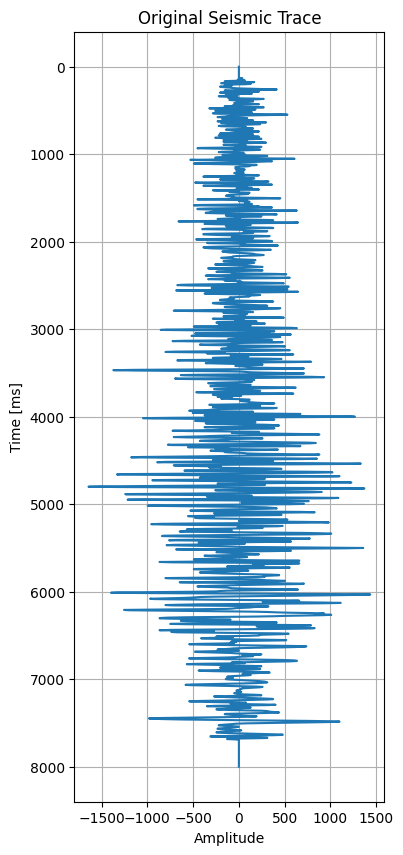

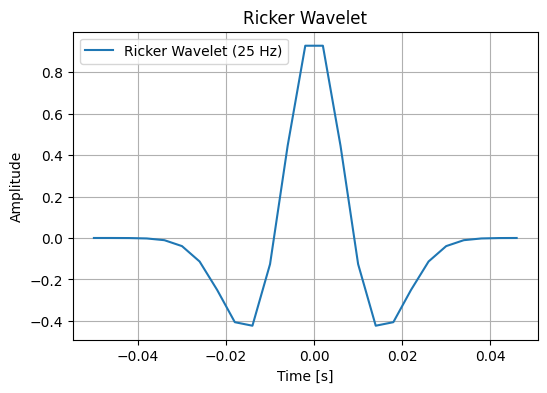

/tmp/ipykernel_88554/585855482.py:48: RuntimeWarning: divide by zero encountered in divide
  reflectivity = np.diff(trace_data) / trace_data[:-1]
/tmp/ipykernel_88554/585855482.py:48: RuntimeWarning: invalid value encountered in divide
  reflectivity = np.diff(trace_data) / trace_data[:-1]


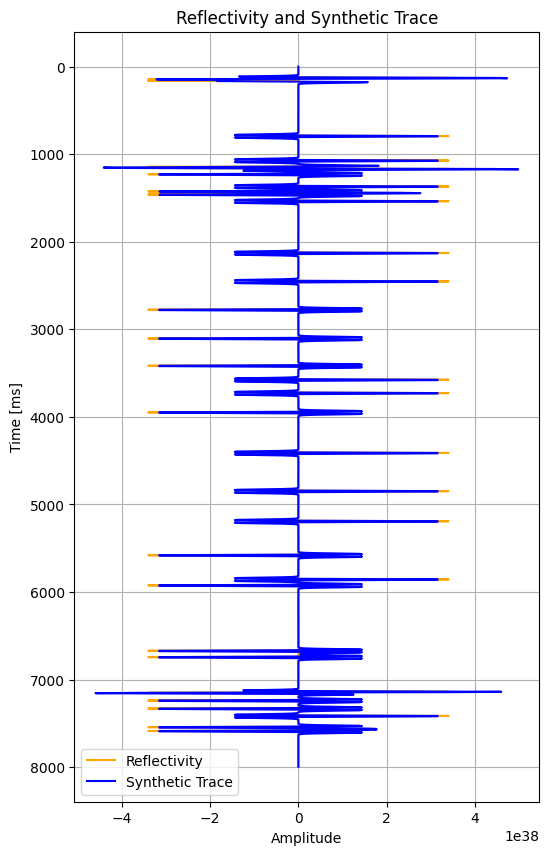

/tmp/ipykernel_88554/585855482.py:77: RuntimeWarning: overflow encountered in scalar multiply
  acoustic_impedance[i] = acoustic_impedance[i - 1] * (1 + reflectivity[i])
/tmp/ipykernel_88554/585855482.py:77: RuntimeWarning: invalid value encountered in scalar multiply
  acoustic_impedance[i] = acoustic_impedance[i - 1] * (1 + reflectivity[i])


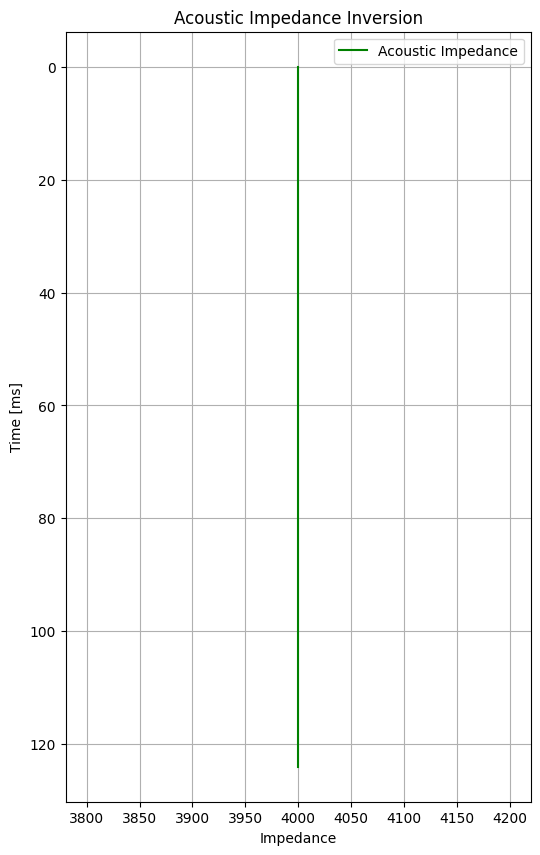

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

# Step 1: Load the SEG-Y file
seismic_data = read("//workspaces//2D--SEGY-ANALYSIS//2DLINE.sgy")

# Extract the first trace data and metadata
trace = seismic_data[0]
trace_data = trace.data  # Amplitude values
sampling_rate = trace.stats.sampling_rate  # Hz
dt = 1.0 / sampling_rate  # Sampling interval (s)
time_axis = np.arange(0, len(trace_data)) * dt  # Time axis (s)

# Plot the original seismic trace
plt.figure(figsize=(4, 10))
plt.plot(trace_data, time_axis * 1000, label="Seismic Trace")
plt.gca().invert_yaxis()
plt.xlabel("Amplitude")
plt.ylabel("Time [ms]")
plt.title("Original Seismic Trace")
plt.grid(True)
plt.show()

# Step 2: Generate a Ricker wavelet (synthetic wavelet)
def ricker_wavelet(frequency, dt, duration):
    t = np.arange(-duration / 2, duration / 2, dt)
    wavelet = (1 - 2 * (np.pi**2) * (frequency**2) * (t**2)) * np.exp(-(np.pi**2) * (frequency**2) * (t**2))
    return t, wavelet

# Define wavelet parameters
freq = 25  # Dominant frequency (Hz)
duration = 0.1  # Wavelet duration (s)
t_wav, wavelet = ricker_wavelet(freq, dt, duration)

# Plot the wavelet
plt.figure(figsize=(6, 4))
plt.plot(t_wav, wavelet, label=f"Ricker Wavelet ({freq} Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Ricker Wavelet")
plt.grid(True)
plt.legend()
plt.show()

# Step 3: Apply the inversion technique
# Create synthetic reflectivity
reflectivity = np.diff(trace_data) / trace_data[:-1]
reflectivity = np.nan_to_num(reflectivity)  # Handle division-by-zero issues

# Convolve the reflectivity with the wavelet to create synthetic seismic data
synthetic_trace = np.convolve(reflectivity, wavelet, mode="same")

# Adjust time_axis for synthetic_trace to match its length
time_axis_synthetic = time_axis[:len(synthetic_trace)]

# Plot the reflectivity and synthetic trace
plt.figure(figsize=(6, 10))
plt.plot(reflectivity, time_axis[:-1] * 1000, label="Reflectivity", color="orange")
plt.plot(synthetic_trace, time_axis_synthetic * 1000, label="Synthetic Trace", color="blue")
plt.gca().invert_yaxis()
plt.xlabel("Amplitude")
plt.ylabel("Time [ms]")
plt.title("Reflectivity and Synthetic Trace")
plt.grid(True)
plt.legend()
plt.show()

# Step 4: Acoustic impedance inversion (Recursive method)
# Assuming the first sample's impedance is known
initial_impedance = 2000 * 2.0  # Example: velocity * density = impedance
acoustic_impedance = np.zeros_like(reflectivity)
acoustic_impedance[0] = initial_impedance

# Compute acoustic impedance
for i in range(1, len(reflectivity)):
    acoustic_impedance[i] = acoustic_impedance[i - 1] * (1 + reflectivity[i])

# Plot the acoustic impedance
plt.figure(figsize=(6, 10))
plt.plot(acoustic_impedance, time_axis[:-1] * 1000, label="Acoustic Impedance", color="green")
plt.gca().invert_yaxis()
plt.xlabel("Impedance")
plt.ylabel("Time [ms]")
plt.title("Acoustic Impedance Inversion")
plt.grid(True)
plt.legend()
plt.show()

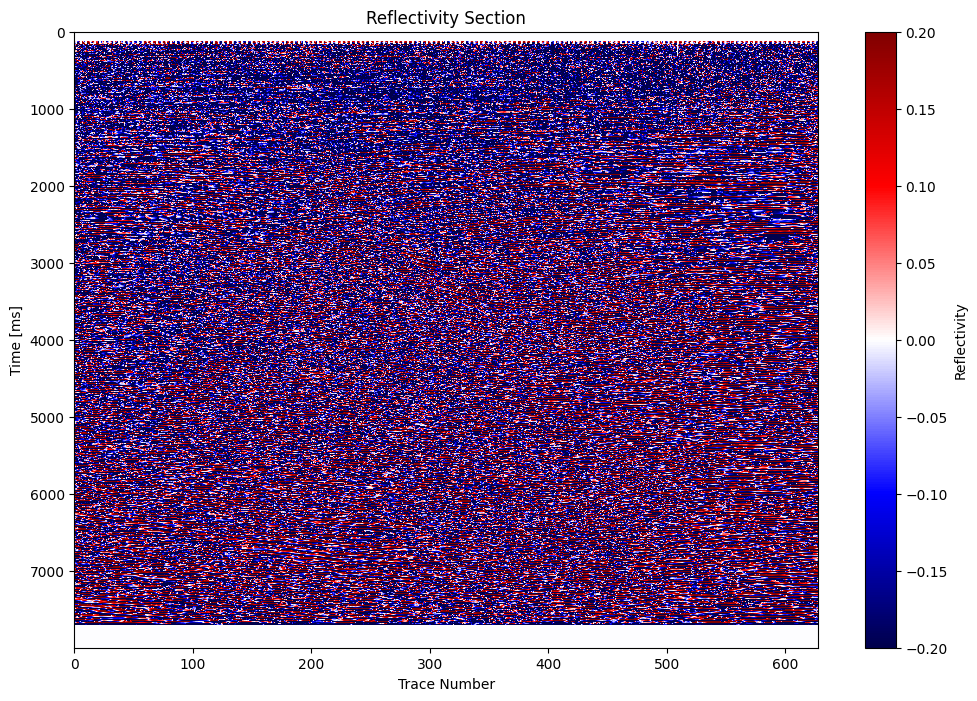

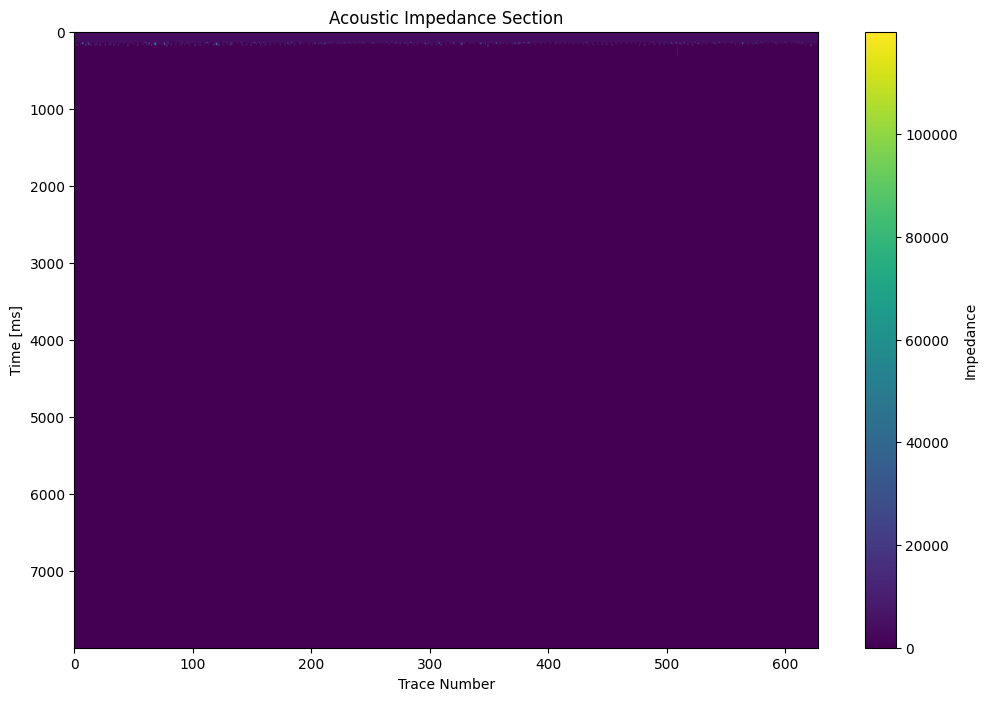

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

# Load SEG-Y file
#seismic_data = read(".sgy")

num_traces = len(seismic_data)
trace_length = len(seismic_data[0].data)
sampling_rate = seismic_data[0].stats.sampling_rate
dt = 1.0 / sampling_rate

# Initialize arrays
reflectivity_section = np.zeros((trace_length - 1, num_traces))
impedance_section = np.zeros((trace_length - 1, num_traces))

# Define Ricker wavelet
def ricker_wavelet(frequency, dt, duration):
    t = np.arange(-duration / 2, duration / 2, dt)
    wavelet = (1 - 2 * (np.pi**2) * (frequency**2) * (t**2)) * np.exp(-(np.pi**2) * (frequency**2) * (t**2))
    return wavelet

wavelet = ricker_wavelet(25, dt, 0.1)

# Set initial impedance
initial_impedance = 4000  # Example impedance (velocity * density)

for i, trace in enumerate(seismic_data):
    trace_data = trace.data.astype(float)  # Ensure numeric type

    # Handle zero values in reflectivity
    epsilon = 1e-6
    reflectivity = np.diff(trace_data) / (trace_data[:-1] + epsilon)
    reflectivity = np.clip(reflectivity, -1, 1)  # Limit extreme values
    reflectivity_section[:, i] = reflectivity  

    # Compute synthetic trace
    synthetic_trace = np.convolve(reflectivity, wavelet, mode="same")

    # Compute acoustic impedance (recursive method)
    acoustic_impedance = np.zeros_like(reflectivity)
    acoustic_impedance[0] = initial_impedance

    for j in range(1, len(reflectivity)):
        acoustic_impedance[j] = acoustic_impedance[j - 1] * (1 + reflectivity[j])
        if np.isnan(acoustic_impedance[j]) or np.isinf(acoustic_impedance[j]):
            acoustic_impedance[j] = acoustic_impedance[j - 1]  # Fix unstable values

    impedance_section[:, i] = acoustic_impedance  

# Plot reflectivity section
time_axis = np.arange(0, trace_length - 1) * dt * 1000
trace_axis = np.arange(num_traces)

plt.figure(figsize=(12, 8))
plt.imshow(
    reflectivity_section,
    aspect="auto",
    extent=[trace_axis[0], trace_axis[-1], time_axis[-1], time_axis[0]],
    cmap="seismic",
    vmin=-0.2,
    vmax=0.2,
)
plt.colorbar(label="Reflectivity")
plt.title("Reflectivity Section")
plt.xlabel("Trace Number")
plt.ylabel("Time [ms]")
plt.show()

# Plot impedance section
plt.figure(figsize=(12, 8))
plt.imshow(
    impedance_section,
    aspect="auto",
    extent=[trace_axis[0], trace_axis[-1], time_axis[-1], time_axis[0]],
    cmap="viridis",
)
plt.colorbar(label="Impedance")
plt.title("Acoustic Impedance Section")
plt.xlabel("Trace Number")
plt.ylabel("Time [ms]")
plt.show()
